# Training Ensemble on MNIST Dataset 
- On the function points branch of nengo
- On the vision branch of nengo_extras

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nengo
import numpy as np
import scipy.ndimage
from scipy.ndimage.interpolation import rotate
import matplotlib.animation as animation
from matplotlib import pylab
from PIL import Image
import nengo.spa as spa
import cPickle
import random

from nengo_extras.data import load_mnist
from nengo_extras.vision import Gabor, Mask

Represent each number using a one-hot where the index of the one represents the digit value

In [2]:
#Encode categorical integer features using a one-hot aka one-of-K scheme.
def one_hot(labels, c=None):
    assert labels.ndim == 1
    n = labels.shape[0]
    c = len(np.unique(labels)) if c is None else c
    y = np.zeros((n, c))
    y[np.arange(n), labels] = 1
    return y

Load the MNIST training and testing images

In [3]:
# --- load the data
img_rows, img_cols = 28, 28

(X_train, y_train), (X_test, y_test) = load_mnist()

X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1

train_targets = one_hot(y_train, 10)
test_targets = one_hot(y_test, 10)

In [4]:
'''
random.seed(1)
#train for all orientations
rotated_X_train = X_train.copy()
for img in rotated_X_train:
    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),
                                                random.randint(1,360),reshape=False,mode="nearest").ravel()
                                                
plt.imshow(np.reshape(rotated_X_train[random.randint(0,1000)],(28,28)),cmap="gray")
'''

'\nrandom.seed(1)\n#train for all orientations\nrotated_X_train = X_train.copy()\nfor img in rotated_X_train:\n    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),\n                                                random.randint(1,360),reshape=False,mode="nearest").ravel()\n                                                \nplt.imshow(np.reshape(rotated_X_train[random.randint(0,1000)],(28,28)),cmap="gray")\n'

## The Network
- The network parameters must be the same here as when the weight matrices are used later on
- The network is made up of an ensemble and two nodes
  - The first connection ( to v) computes the weights from the activities of the images to the images themselves
  - The second connection (to v2) computes the weights from the activities of the images to the labels
  
  

In [4]:
rng = np.random.RandomState(9)

# --- set up network parameters
#Want to encode and decode the image
n_vis = X_train.shape[1]
n_out =  X_train.shape[1]
#number of neurons/dimensions of semantic pointer
n_hid = 1000 #Try with more neurons for more accuracy


#Want the encoding/decoding done on the training images
ens_params = dict(
    eval_points=X_train, #rotated_X_train
    neuron_type=nengo.LIF(), #Why not use LIF? originally used LIFRate()
    intercepts=nengo.dists.Choice([-0.5]),
    max_rates=nengo.dists.Choice([100]),
    )


#Least-squares solver with L2 regularization.
solver = nengo.solvers.LstsqL2(reg=0.01)
#solver = nengo.solvers.LstsqL2(reg=0.0001)
solver2 = nengo.solvers.LstsqL2(reg=0.01)

#network that generates the weight matrices between neuron activity and images and the labels
with nengo.Network(seed=3) as model:
    a = nengo.Ensemble(n_hid, n_vis, seed=3, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None,
        eval_points=X_train, function=X_train,#want the same thing out (identity) #X_train
        solver=solver)
    
    v2 = nengo.Node(size_in=train_targets.shape[1])
    conn2 = nengo.Connection(
        a, v2, synapse=None,
        eval_points=X_train, function=train_targets, #Want to get the labels out
        solver=solver2)

'''
degrees = 6
#must have same number of excoders as neurons (Want each random encoder to have same encoder at every angle)
encoders = Gabor().generate(n_hid/(360/degrees), (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)

rotated_encoders = encoders.copy()


#For each randomly generated encoder, create the same encoder at every angle (increments chosen by degree)
for encoder in encoders:
    rotated_encoders = np.append(rotated_encoders, [encoder],axis =0)
    for i in range(1,59):
        #new_gabor = rotate(encoder.reshape(28,28),degrees*i,reshape = False).ravel()
        rotated_encoders = np.append(rotated_encoders, [rotate(encoder.reshape(28,28),degrees*i,reshape = False).ravel()],axis =0)
        #rotated_encoders = np.append(rotated_encoders, [encoder],axis =0)

'''
rotated_encoders = cPickle.load(open("encoders.p", "r"))

print(rotated_encoders.shape)

#Num of neurons does not divide evenly with 6 degree increments, so add random encoders
extra_encoders = Gabor().generate(n_hid - len(rotated_encoders), (11, 11), rng=rng)
extra_encoders = Mask((28, 28)).populate(extra_encoders, rng=rng, flatten=True)
all_encoders = np.append(rotated_encoders, extra_encoders, axis =0)


a.encoders = all_encoders
print(len(all_encoders))


(660L, 784L)
1000


In [ ]:
'''Old encoders
# linear filter used for edge detection as encoders, more plausible for human visual system
encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
#Set the ensembles encoders to this
a.encoders = encoders

#Check the encoders were correctly made
plt.imshow(encoders[0].reshape(28, 28), vmin=encoders[0].min(), vmax=encoders[0].max(), cmap='gray')
'''


## Evaluating the network statically
- Functions for computing representation of the image at different levels of encoding/decoding
- get_outs  returns the output of the network
- able to evaluate on many images
- no need to run the simulator

In [5]:
#Get the one hot labels for the images
def get_outs(sim, images):
    #The activity of the neurons when an image is given as input
    _, acts = nengo.utils.ensemble.tuning_curves(a, sim, inputs=images)
    #The activity multiplied by the weight matrix (calculated in the network) to give the one-hot labels
    return np.dot(acts, sim.data[conn2].weights.T)

#Check how many of the labels were produced correctly
#def get_error(sim, images, labels):
#    return np.argmax(get_outs(sim, images), axis=1) != labels

#Get label of the images
#def get_labels(sim,images):
#    return np.argmax(get_outs(sim, images), axis=1)

#Get the neuron activity of an image or group of images (this is the semantic pointer in this case)
def get_activities(sim, images):
    _, acts = nengo.utils.ensemble.tuning_curves(a, sim, inputs=images)
    return acts

#Get the representation of the image after it has gone through the encoders (Gabor filters) but before it is in the neurons
#This must be computed to create the weight matrix for rotation from neuron activity to this step
# This allows a recurrent connection to be made from the neurons to themselves later
def get_encoder_outputs(sim,images):
    #Pass the images through the encoders
    outs = np.dot(images,sim.data[a].encoders.T) #before the neurons 
    return outs

## Images
Create lists of training and testing images
- Original images at random orientations
- Those images rotated a fixed amount more
- Images not used for training, but later for testing

In [ ]:
'''
def intense(img):
    newImg = img.copy()
    newImg[newImg < 0] = -1
    newImg[newImg > 0] = 1
    return newImg

def filtered(img):
    return intense(scipy.ndimage.gaussian_filter(img, sigma=1))
'''

In [6]:
degrees = 6

#Images to train, starting at random orientation
orig_imgs = X_train[:100000].copy()
for img in orig_imgs:
    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),
                                                (np.random.randint(360)),reshape=False,mode="nearest").ravel()

#Images rotated a fixed amount from the original random orientation
rotated_imgs =orig_imgs.copy()
for img in rotated_imgs:
    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),degrees,reshape=False,mode="nearest").ravel()

    #^get the encoder outputs of this^
    
#Images not used for training, but for testing (all at random orientations)
test_imgs = X_test[:1000].copy()
for img in test_imgs:
    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),
                                                (np.random.randint(360)),reshape=False,mode="nearest").ravel()


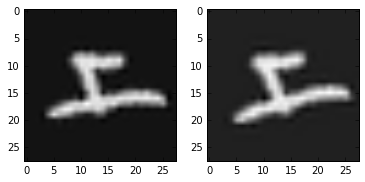

In [7]:
#Check to make sure images were generated correctly
i= np.random.randint(0,1000)
plt.subplot(121)
plt.imshow(np.reshape(orig_imgs[i],(28,28)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(rotated_imgs[i],(28,28)), cmap='gray')


## Simulator
- Calculate the neuron activities of each set of images
- Calculate the labels of the original images
- Calculate the rotated images after they have gone through the encoders, but before they are in neuron activity
- Generate the weight matrices between 
  - original activities and rotated activities
  - labels and image activities
  - original activities and rotated images through the encoders

In [8]:
with nengo.Simulator(model) as sim:    
    
    #Neuron activities of different mnist images
    #The semantic pointers
    orig_acts = get_activities(sim,orig_imgs)
    rotated_acts = get_activities(sim,rotated_imgs)
    test_acts = get_activities(sim,test_imgs)
    
    X_test_acts = get_activities(sim,X_test)
    labels_out = get_outs(sim,X_test)
    
    rotated_after_encoders = get_encoder_outputs(sim,rotated_imgs)
    
    #solvers for a learning rule
    solver_tranform = nengo.solvers.LstsqL2(reg=1e-8)
    solver_word = nengo.solvers.LstsqL2(reg=1e-8)
    solver_rotate_encoder = nengo.solvers.LstsqL2(reg=1e-6)
    
    
    #find weight matrix between neuron activity of the original image and the rotated image
    #weights returns a tuple including information about learning process, just want the weight matrix
    #weights,_ = solver_tranform(orig_acts, rotated_acts)
    
    #find weight matrix between labels and neuron activity
    label_weights,_ = solver_word(labels_out,X_test_acts)
    
    
    rotated_after_encoder_weights,_ = solver_rotate_encoder(orig_acts,rotated_after_encoders)
    
    
    

# Saving weight matrices


In [9]:
filename = "label_weights_choose_enc" + str(n_hid) +".p"
cPickle.dump(label_weights, open( filename, "wb" ) )

filename = "activity_to_img_weights_choose_enc" + str(n_hid) +".p"
cPickle.dump(sim.data[conn].weights.T, open( filename, "wb" ) )

#filename = "rotation_clockwise_weights" + str(n_hid) +".p"
#cPickle.dump(weights, open( filename, "wb" ) )

filename = "rotated_counter_after_encoder_weights_choose_enc" + str(n_hid) +".p"
cPickle.dump(rotated_after_encoder_weights, open( filename, "wb" ) )
